In [1]:
# Imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import numpy as np
import pandas as pd
import re
import seaborn as sns
import contractions
import operator
import matplotlib.pyplot as plt
from itertools import islice
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix

from seqeval.metrics import f1_score
from seqeval.scheme import IOB2

from tqdm import tqdm

import spacy
nlp = spacy.load("en_core_web_sm")
from spacy.tokenizer import Tokenizer
tokenizer = Tokenizer(nlp.vocab)

# Set device = CUDA if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: ', device)

Device:  cpu


In [2]:
# Reading CSV File into Pandas DataFrame

# Reading Train Dataset into DataFrame
dataF = pd.read_csv('Data/hw2_train.csv', index_col = 0)
dataF.columns = ['texts', 'tags']
print('Train Set Shape:', dataF.shape)
# print(dataF.tail())

# Removing unequal texts and tags from train dataset
list_of_dict = []
for idx, row in dataF.iterrows():
    temp_dict = {}
    len_text = len(row['texts'].split())
    len_tag = len(row['tags'].split())
    if(len_text == len_tag):
        temp_dict['texts'] = row['texts']
        temp_dict['tags'] = row['tags']
        list_of_dict.append(temp_dict)
df = pd.DataFrame.from_dict(list_of_dict)
print('Train Set with unequal rows removed Shape: ', df.shape)
# print(df.tail())

# Reading Test Dataset into DataFrame
test_data = pd.read_csv('Data/hw2_test.csv', index_col = 0)
test_data.columns = ['texts']
print('Test Set Shape:', test_data.shape)
# print(test_df.tail())

Train Set Shape: (2312, 2)
Train Set with unequal rows removed Shape:  (2253, 2)
Test Set Shape: (981, 1)


In [72]:
# Splitting the Training dataset into the Training set and Validation set
train_data, val_data = train_test_split(df,
                                        random_state = 0, 
                                        test_size = 0.25, 
                                        shuffle = True)
print('Train Data Shape: ', train_data.shape)
print('Test Data Shape: ', val_data.shape)

Train Data Shape:  (1689, 2)
Test Data Shape:  (564, 2)


In [74]:
# Pre-Trained GloVe Word Embeddings
glove = pd.read_csv('Data/gloVe/glove.840B.300d.txt', sep = ' ', quoting = 3, header = None, index_col = 0)
glove_embedding = {key: val.values for key, val in glove.T.items()}
print(len(glove_embedding))

2196009


In [77]:
# Create NumPy Array for Vocab and Emeddings
vocab = list(glove_embedding.keys())
embeddings = list(glove_embedding.values())

vocab = np.array(vocab)
embeddings = np.array(embeddings)
print('Vocab Shape: ', vocab.shape)
print('Embeddings Shape: ', embeddings.shape)

Vocab Shape:  (2196009,)
Embeddings Shape:  (2196009, 300)


In [79]:
# Insert '<pad>' and '<unk>' tokens at start of vocab
vocab = np.insert(vocab, 0, '<pad>')
vocab = np.insert(vocab, 1, '<unk>')
print(vocab.shape)

# Insert embeddings for pad and unk tokens at top of embeddings
embedding_pad = np.zeros((1, 
                          embeddings.shape[1]))
embedding_unk = np.mean(embeddings, 
                        axis = 0, 
                        keepdims = True)
embeddings = np.vstack((embedding_pad, 
                        embedding_unk, 
                        embeddings))
print(embeddings.shape)

(2196013,)
(2196013, 300)


In [80]:
# Dictionary for words
word2idx = { term: idx for idx, term in enumerate(vocab) }
word2idx['<pad>'] = 0
word2idx['<unk>'] = 1
idx2word = { idx: word for word,idx in word2idx.items() }
# print(len(word2idx))

# for k,v in sorted(word2idx.items(), key = operator.itemgetter(1))[:50]:
#     print(k,v)

# Dicitionary for tags
tag_set = set()
tag_count_dict = {}
for index, row in df.iterrows():
    temp = row['tags'].split()
    for item in temp:
        tag_set.add(item)
        if item not in tag_count_dict:
            tag_count_dict[item] = 1
        else:
            tag_count_dict[item] = tag_count_dict[item] + 1

tag2idx = { tag: idx for idx, tag in enumerate(tag_set) }
idx2tag = { idx: word for word, idx in tag2idx.items() }
print(idx2tag)

TAG_COUNT = len(tag2idx)
print(TAG_COUNT)

{0: 'I_mpaa_rating', 1: 'B_language', 2: 'O', 3: 'I_producer', 4: 'B_director', 5: 'I_release_year', 6: 'I-movie', 7: 'B_char', 8: 'I_genre', 9: 'B_person', 10: 'B_mpaa_rating', 11: 'B_location', 12: 'I_subject', 13: 'B_subject', 14: 'B_country', 15: 'B_genre', 16: 'I_movie', 17: 'I_language', 18: 'I_cast', 19: 'I_person', 20: 'B_cast', 21: 'I_char', 22: 'B_release_year', 23: 'I_country', 24: 'B_producer', 25: 'B_movie', 26: 'I_director'}
27


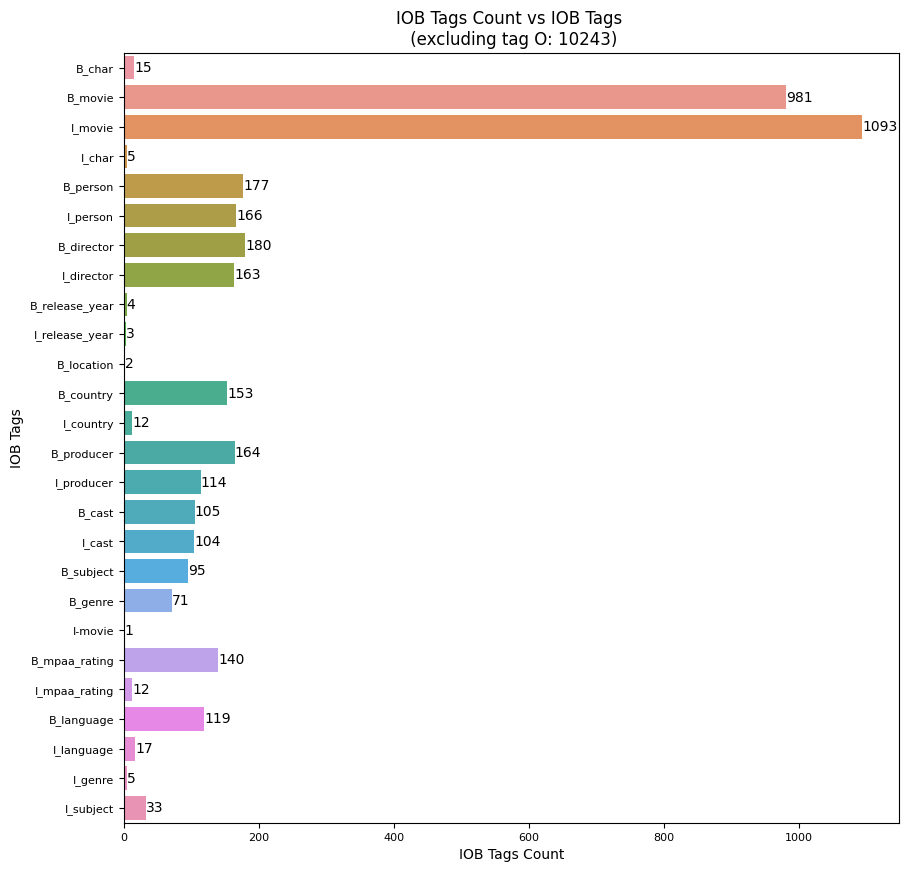

In [125]:
# Representation of Tags in the Dataset
tag_names = list(tag_count_dict.keys())
o_tag = tag_names.pop(0)

tag_count = list(tag_count_dict.values())
o_tag_count = tag_count.pop(0)

tag_df = pd.DataFrame({"iob_tags_count": tag_count, "iob_tags": tag_names})
plt.figure(figsize = (10, 10))
splot = sns.barplot(x = "iob_tags_count", y = "iob_tags" , data = tag_df, orient ='h')
splot.bar_label(splot.containers[0], color='black')
plt.xlabel("IOB Tags Count", size = 10)
plt.ylabel("IOB Tags", size = 10)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.title("IOB Tags Count vs IOB Tags \n (excluding tag %s: %d)" %(o_tag, o_tag_count))

plt.savefig('Images/tag_count.png')

In [81]:
# SlotTagger Class for DataLoader
class SlotTaggerDataset(Dataset):
    
    def __init__(self, 
                 data: pd.DataFrame):
        self.data = data
        self.texts = self.data['texts']
        if 'tags' in self.data.columns:
            self.tags = self.data['tags']
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, 
                    idx: int):
        # Enoding Text
        text = self.texts.iloc[idx]
        encoded_text = self.encode_text(text)
        
        # Encoding Tags if they exist
        if 'tags' in self.data.columns:
            tag = self.tags.iloc[idx]
            encoded_tag = self.encode_tag(tag)
            return encoded_text, encoded_tag 
        else:
            return encoded_text
        
    # Tokenize    
    def tokenize(self, 
                 text: str):
        return [i.text for i in tokenizer(text)]
    
    # Encode Text
    def encode_text(self, 
                    text):
        text_list = [word for word in self.tokenize(text)]
        text_vector = []
        for word in text_list:
            if word in word2idx:
                text_vector.append(word2idx[word])
            else:
                text_vector.append(1)
        return text_vector
    
    # Enocde Tags
    def encode_tag(self, 
                   tag):
        tag_list = [word for word in self.tokenize(tag)]
        tag_vector = [tag2idx[word] for word in tag_list]
        return tag_vector

In [82]:
# Slot Tagger Object for DataLoader
train_ds = SlotTaggerDataset(train_data)
# print(train_ds[0])
val_ds = SlotTaggerDataset(val_data)
# print(val_ds[0])
test_ds = SlotTaggerDataset(test_data)
# print(test_ds[0])

In [83]:
# PyTorch Data Loader
def custom_collate_fn(batch):
    if isinstance(batch[0], list):
        texts_tensor = [torch.tensor(text) for text in batch]

        lengths = [len(text) for text in batch]
        lengths = torch.tensor(lengths)

        texts_padded = pad_sequence(texts_tensor, batch_first = True, padding_value = 0)

        return texts_padded, lengths

    else:
        texts, tags = zip(*batch)

        texts_tensor = [torch.tensor(text) for text in texts]
        tags_tensor = [torch.tensor(tag) for tag in tags]

        lengths = [len(text) for text in texts]
        lengths = torch.tensor(lengths)

        texts_padded = pad_sequence(texts_tensor, batch_first = True, padding_value = 0)
        tags_padded = pad_sequence(tags_tensor, batch_first = True, padding_value = 0)

        return texts_padded, tags_padded, lengths

BATCH_SIZE = 32

train_loader = DataLoader(train_ds, 
                          batch_size = BATCH_SIZE, 
                          shuffle = True, 
                          collate_fn = custom_collate_fn)
val_loader = DataLoader(val_ds, 
                        batch_size = BATCH_SIZE, 
                        shuffle = True, 
                        collate_fn = custom_collate_fn)

test_loader = DataLoader(test_ds, 
                        batch_size = 1, 
                        shuffle = False, 
                        collate_fn = custom_collate_fn)

# print(list(islice(train_loader, 1)))

assert train_data.shape[0] == len(train_loader.dataset)
assert val_data.shape[0] == len(val_loader.dataset)
assert test_data.shape[0] == len(test_loader.dataset)

In [ ]:
# # Uni-LSTM Model with 2 hidden layers
# class LSTM(nn.Module):
#     def __init__(self, 
#                  embedding_dim, 
#                  hidden_dim, 
#                  output_dim, 
#                  n_layers, 
#                  bidirectional, 
#                  dropout):
#         super().__init__()
        
#         # Initialize Embedding Layer with Pre-Trained Embeddings (Vector Sequences)
#         self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embeddings).float())
#         # LSTM layer process the vector sequences 
#         self.lstm = nn.LSTM(embedding_dim, 
#                             hidden_dim,
#                             num_layers = n_layers,
#                             bidirectional = bidirectional,
# #                             dropout = dropout,
#                             batch_first = True)
# #         # We use dropout before the final layer to improve with regularization
# #         self.dropout = nn.Dropout(dropout)
#         # Dense layer to predict 
#         self.fc = nn.Linear(hidden_dim, output_dim)
        
#     def forward(self, 
#                 x, 
#                 x_lengths):
#         embedded = self.embedding(x)
#         packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, 
#                                                             x_lengths, 
#                                                             batch_first = True, 
#                                                             enforce_sorted = False) # Pack sequence
#         packed_output, (hidden, cell) = self.lstm(packed_embedded)
#         output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, 
#                                                                   batch_first = True) # Unpack sequence
# #         output = self.dropout(output)
#         output = self.fc(output)
#         return output

In [84]:
# Bi-LSTM Model with 2 hidden layers
class LSTM(nn.Module):
    def __init__(self, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim, 
                 n_layers, 
                 bidirectional, 
                 dropout):
        super().__init__()
        
        # Initialize Embedding Layer with Pre-Trained Embeddings (Vector Sequences)
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embeddings).float())
        # LSTM layer process the vector sequences 
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim,
                            num_layers = n_layers,
                            bidirectional = bidirectional,
#                             dropout = dropout,
                            batch_first = True)
        num_directions = 2 if bidirectional else 1
        # Dense layers to predict 
        self.fc = nn.Linear(hidden_dim * num_directions, output_dim)
#         # We use dropout before the final layer to improve with regularization
#         self.dropout = nn.Dropout(dropout)
        
    def forward(self, 
                x, 
                x_lengths):
        embedded = self.embedding(x)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, 
                                                            x_lengths, 
                                                            batch_first = True, 
                                                            enforce_sorted = False) # Pack sequence
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, 
                                                                  batch_first = True) # Unpack sequence
#         output = output[:, -1, :]
        output = self.fc(output)
        return output

In [85]:
torch.manual_seed(32)

EMBEDDING_DIM = embeddings.shape[1]
HIDDEN_DIM = 20
OUTPUT_DIM = TAG_COUNT
NUM_LAYERS = 2
BIDIRECTION = True
DROPOUT = 0.2

model = LSTM(EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            NUM_LAYERS, 
            BIDIRECTION, 
            DROPOUT).to(device)

print(model)

LSTM(
  (embedding): Embedding(2196013, 300)
  (lstm): LSTM(300, 20, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=40, out_features=27, bias=True)
)


In [86]:
def squeezed_list(my_list):
    temp_list = [int(element) for element in my_list]
    return temp_list  

def slice_list(my_list, slice_increment):
    return [my_list[i : i + slice_increment] for i in range(0, len(my_list), slice_increment)]

def convert_idx_to_tags(lol, isTensor):
    iob_list = []
    for list_element in lol:
        if (isTensor):
            list_element = list_element.numpy() 
        iob = [idx2tag[index] for index in list_element]
        iob_list.append(iob)
    return iob_list

In [87]:
# Model Train Function
def train(loader, 
          model, 
          optimizer, 
          loss_fn):
    model.train()
    losses = []
    pbar = tqdm(loader)
    for x, y, lengths in pbar:
        optimizer.zero_grad()
        
        y_pred = model(x, lengths)
        
        y_pred = y_pred.view(-1, y_pred.shape[-1])
        y = torch.flatten(y)
        
        loss = loss_fn(y_pred, y)
        pbar.set_postfix({'Loss': loss.item()})
        losses.append(loss.item())
        
        # Calculate gradients for w/b
        loss.backward()  
        # Update weights according to optimizer rules
        optimizer.step()          
    return sum(losses) / len(losses)

# Model Evaluate Function
def evaluate(loader, 
             model, 
             loss_fn, 
             score_fn):
    model.eval()
    losses = []
    for x, y, lengths in tqdm(loader):
        y_pred = model(x, lengths)
        
        max_len = x.shape[1]
              
        y_pred = y_pred.view(-1, y_pred.shape[-1])
        y = torch.flatten(y)
        

        loss = loss_fn(y_pred, y)
        losses.append(loss.item())
        
        tags_iob = convert_idx_to_tags(slice_list(y, max_len), True)

        max_preds = y_pred.argmax(dim = 1, keepdim = True) # Get the index of the max probability
        predictions_iob = convert_idx_to_tags(slice_list((squeezed_list(max_preds)), max_len), False)
    
    score = score_fn(tags_iob, predictions_iob, scheme = IOB2)
    return tags_iob, predictions_iob, sum(losses) / len(losses), score

In [127]:
# Model Training on Train dataset and Evaluation on Validation dataset
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.01)
loss_fn = nn.CrossEntropyLoss().to(device)
score_fn = f1_score

train_loss_list = []
val_loss_list = []
f1_score_list = []
n_epochs = 100
best_acc = 0
PATH = f'best-model.pt'

for epoch in range(n_epochs):
    # Model Training
    train_loss = train(train_loader, 
                     model, 
                     optimizer, 
                     loss_fn)
    print('Train Loss: ', train_loss)
    train_loss_list.append(train_loss)
    
    # Model Evaluation
    tags, predictions, val_loss, accuracy = evaluate(val_loader, 
                                                       model, 
                                                       loss_fn, 
                                                       score_fn)
    print('Val Accuracy: ', accuracy)
    print('Val Loss: ', val_loss)
    val_loss_list.append(val_loss)
    f1_score_list.append(accuracy)
    
    # Save model if Validation F1_Score is greather than 75%
    if accuracy > best_acc and accuracy > 0.75:
        torch.save(model.state_dict(), PATH)
#         cm = multilabel_confusion_matrix(labels, predictions)

100%|█████████████████████████████| 53/53 [00:00<00:00, 87.92it/s, Loss=8.53e-5]


Train Loss:  0.00425134556719127


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 231.45it/s]
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_movie seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_movie seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_mpaa_rating seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_country seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-package

Val Accuracy:  0.9610389610389611
Val Loss:  0.19785157301359707


100%|████████████████████████████| 53/53 [00:00<00:00, 111.15it/s, Loss=0.00356]


Train Loss:  0.003997008976477686


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 247.71it/s]
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_genre seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_release_year seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_subject seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_genre seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packag

Val Accuracy:  0.8095238095238095
Val Loss:  0.17914690946539244


100%|████████████████████████████| 53/53 [00:00<00:00, 115.27it/s, Loss=3.35e-5]


Train Loss:  0.006360585806245546


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 246.48it/s]
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_char seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


Val Accuracy:  0.8048780487804877
Val Loss:  0.19874964783796006


100%|████████████████████████████| 53/53 [00:00<00:00, 115.56it/s, Loss=0.00011]


Train Loss:  0.0021539302526331805


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 251.76it/s]


Val Accuracy:  0.9230769230769231
Val Loss:  0.1727914706700378


100%|███████████████████████████| 53/53 [00:00<00:00, 112.64it/s, Loss=0.000272]


Train Loss:  0.0032644911610437907


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 257.09it/s]
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_country seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


Val Accuracy:  0.9589041095890412
Val Loss:  0.1668222633500894


100%|███████████████████████████| 53/53 [00:00<00:00, 117.81it/s, Loss=0.000369]


Train Loss:  0.0023224137648352517


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 252.22it/s]


Val Accuracy:  0.8947368421052632
Val Loss:  0.1633503477399548


100%|████████████████████████████| 53/53 [00:00<00:00, 119.80it/s, Loss=0.00015]


Train Loss:  0.0017877387025400134


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 274.14it/s]
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_subject seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


Val Accuracy:  0.9230769230769231
Val Loss:  0.17933209406005013


100%|███████████████████████████| 53/53 [00:00<00:00, 110.84it/s, Loss=0.000341]


Train Loss:  0.001800578800526328


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 251.72it/s]


Val Accuracy:  0.9230769230769231
Val Loss:  0.1906510852277279


100%|████████████████████████████| 53/53 [00:00<00:00, 113.41it/s, Loss=1.75e-5]


Train Loss:  0.0009403254926786209


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 261.30it/s]


Val Accuracy:  0.9090909090909091
Val Loss:  0.17422396089467737


100%|████████████████████████████| 53/53 [00:00<00:00, 114.42it/s, Loss=4.03e-5]


Train Loss:  0.0006220783150226607


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 262.20it/s]


Val Accuracy:  0.9249999999999999
Val Loss:  0.18171133287250996


100%|████████████████████████████| 53/53 [00:00<00:00, 118.58it/s, Loss=3.65e-5]


Train Loss:  0.0006458462575605119


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 266.94it/s]


Val Accuracy:  0.9863013698630138
Val Loss:  0.18749309983104467


100%|████████████████████████████| 53/53 [00:00<00:00, 118.50it/s, Loss=1.91e-5]


Train Loss:  0.00033016104598058483


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 264.13it/s]


Val Accuracy:  0.9210526315789473
Val Loss:  0.17444929832385647


100%|████████████████████████████| 53/53 [00:00<00:00, 117.72it/s, Loss=4.37e-5]


Train Loss:  0.00028425019198313647


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 253.34it/s]


Val Accuracy:  0.9333333333333332
Val Loss:  0.18498613892330062


100%|████████████████████████████| 53/53 [00:00<00:00, 119.34it/s, Loss=3.51e-5]


Train Loss:  0.0003305662546994907


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 261.56it/s]
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_language seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


Val Accuracy:  0.9333333333333332
Val Loss:  0.1813600468966696


100%|████████████████████████████| 53/53 [00:00<00:00, 118.82it/s, Loss=3.67e-5]


Train Loss:  0.00028283749175246175


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 258.04it/s]


Val Accuracy:  0.9599999999999999
Val Loss:  0.16938584701468548


100%|████████████████████████████| 53/53 [00:00<00:00, 114.50it/s, Loss=1.81e-5]


Train Loss:  0.0002530244787178746


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 258.04it/s]


Val Accuracy:  0.918918918918919
Val Loss:  0.18891659741186434


100%|████████████████████████████| 53/53 [00:00<00:00, 118.34it/s, Loss=1.34e-5]


Train Loss:  0.0002321450745357823


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 254.66it/s]


Val Accuracy:  0.9166666666666666
Val Loss:  0.1734922043979168


100%|████████████████████████████| 53/53 [00:00<00:00, 117.49it/s, Loss=1.96e-5]


Train Loss:  0.0002729705306849627


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 261.09it/s]


Val Accuracy:  0.9473684210526315
Val Loss:  0.18582992752393088


100%|████████████████████████████| 53/53 [00:00<00:00, 118.01it/s, Loss=2.28e-5]


Train Loss:  0.0002486414618084931


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 262.35it/s]


Val Accuracy:  0.9210526315789475
Val Loss:  0.2018123318751653


100%|████████████████████████████| 53/53 [00:00<00:00, 119.57it/s, Loss=2.16e-5]


Train Loss:  0.0002320865970809877


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 266.55it/s]


Val Accuracy:  0.9487179487179487
Val Loss:  0.17845871340897349


100%|████████████████████████████| 53/53 [00:00<00:00, 119.17it/s, Loss=2.39e-5]


Train Loss:  0.00023169853758825515


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 248.51it/s]


Val Accuracy:  0.935064935064935
Val Loss:  0.17881927494373587


100%|████████████████████████████| 53/53 [00:00<00:00, 119.52it/s, Loss=1.88e-5]


Train Loss:  0.0002621569834394355


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 247.62it/s]


Val Accuracy:  0.9135802469135802
Val Loss:  0.18602592622240385


100%|████████████████████████████| 53/53 [00:00<00:00, 117.64it/s, Loss=0.00288]


Train Loss:  0.00024111702667673767


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 247.72it/s]


Val Accuracy:  0.9873417721518987
Val Loss:  0.17564425374277765


100%|████████████████████████████| 53/53 [00:00<00:00, 115.49it/s, Loss=2.75e-5]


Train Loss:  0.0002294894364000219


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 259.88it/s]


Val Accuracy:  0.9487179487179487
Val Loss:  0.18604204969273674


100%|████████████████████████████| 53/53 [00:00<00:00, 118.87it/s, Loss=1.83e-5]


Train Loss:  0.0002541396544752645


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 270.66it/s]


Val Accuracy:  0.9230769230769231
Val Loss:  0.19821683327770895


100%|████████████████████████████| 53/53 [00:00<00:00, 119.61it/s, Loss=8.43e-6]


Train Loss:  0.0003172250840179913


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 266.90it/s]


Val Accuracy:  0.8831168831168831
Val Loss:  0.18114429319070446


100%|████████████████████████████| 53/53 [00:00<00:00, 121.09it/s, Loss=2.75e-5]


Train Loss:  0.0002217751523489223


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 269.15it/s]


Val Accuracy:  0.9610389610389611
Val Loss:  0.18743739587565264


100%|████████████████████████████| 53/53 [00:00<00:00, 121.21it/s, Loss=1.44e-5]


Train Loss:  0.0002806593283221103


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 267.60it/s]


Val Accuracy:  0.918918918918919
Val Loss:  0.18566499546998078


100%|████████████████████████████| 53/53 [00:00<00:00, 119.81it/s, Loss=2.72e-5]


Train Loss:  0.00024674767366875285


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 270.55it/s]


Val Accuracy:  0.9333333333333332
Val Loss:  0.19093087605304188


100%|████████████████████████████| 53/53 [00:00<00:00, 121.59it/s, Loss=1.44e-5]


Train Loss:  0.00024461848442166776


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 280.61it/s]


Val Accuracy:  0.9565217391304348
Val Loss:  0.19116466927031675


100%|████████████████████████████| 53/53 [00:00<00:00, 120.32it/s, Loss=1.09e-5]


Train Loss:  0.00023596629216626752


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 270.86it/s]


Val Accuracy:  0.9863013698630138
Val Loss:  0.1837585473743578


100%|████████████████████████████| 53/53 [00:00<00:00, 118.76it/s, Loss=2.35e-5]


Train Loss:  0.00022354742686987283


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 265.33it/s]


Val Accuracy:  0.918918918918919
Val Loss:  0.18933053521646392


100%|████████████████████████████| 53/53 [00:00<00:00, 119.48it/s, Loss=6.39e-6]


Train Loss:  0.00025600447589945444


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 268.30it/s]


Val Accuracy:  0.9066666666666667
Val Loss:  0.18753741992016634


100%|████████████████████████████| 53/53 [00:00<00:00, 119.58it/s, Loss=1.33e-5]


Train Loss:  0.0002590265947150809


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 252.26it/s]


Val Accuracy:  0.9156626506024096
Val Loss:  0.19066166463825437


100%|████████████████████████████| 53/53 [00:00<00:00, 120.06it/s, Loss=4.28e-6]


Train Loss:  0.0003070951982683152


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 256.29it/s]


Val Accuracy:  0.9863013698630138
Val Loss:  0.19499991741031408


100%|████████████████████████████| 53/53 [00:00<00:00, 120.40it/s, Loss=1.97e-5]


Train Loss:  0.00024220170828228666


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 261.45it/s]


Val Accuracy:  0.8767123287671232
Val Loss:  0.1918251762787501


100%|████████████████████████████| 53/53 [00:00<00:00, 119.48it/s, Loss=3.75e-6]


Train Loss:  0.00019335964496452297


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 269.92it/s]


Val Accuracy:  1.0
Val Loss:  0.18014053794710586


100%|████████████████████████████| 53/53 [00:00<00:00, 120.30it/s, Loss=4.41e-6]


Train Loss:  0.00024120647896419336


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 270.95it/s]


Val Accuracy:  0.8974358974358975
Val Loss:  0.19432545929319328


100%|████████████████████████████| 53/53 [00:00<00:00, 119.92it/s, Loss=1.15e-5]


Train Loss:  0.00024342283593384463


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 270.49it/s]


Val Accuracy:  0.9315068493150684
Val Loss:  0.19424502758516204


100%|█████████████████████████████| 53/53 [00:00<00:00, 119.45it/s, Loss=0.0155]


Train Loss:  0.0003734222508520138


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 266.79it/s]


Val Accuracy:  0.9090909090909091
Val Loss:  0.21201290749013424


100%|████████████████████████████| 53/53 [00:00<00:00, 122.50it/s, Loss=7.04e-6]


Train Loss:  0.000380984866472678


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 268.92it/s]


Val Accuracy:  0.9473684210526315
Val Loss:  0.1913522072136402


100%|████████████████████████████| 53/53 [00:00<00:00, 120.22it/s, Loss=5.78e-6]


Train Loss:  0.00021654098018961172


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 272.24it/s]


Val Accuracy:  0.9589041095890412
Val Loss:  0.1950040575530794


100%|████████████████████████████| 53/53 [00:00<00:00, 119.40it/s, Loss=6.86e-6]


Train Loss:  0.000316054927933057


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 266.69it/s]


Val Accuracy:  0.868421052631579
Val Loss:  0.19936573546793726


100%|████████████████████████████| 53/53 [00:00<00:00, 120.29it/s, Loss=3.55e-6]


Train Loss:  0.0002499418165130782


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 274.12it/s]


Val Accuracy:  0.8571428571428572
Val Loss:  0.19705914121328127


100%|███████████████████████████████| 53/53 [00:00<00:00, 120.48it/s, Loss=1e-5]


Train Loss:  0.0003499898610089248


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 264.34it/s]


Val Accuracy:  0.9367088607594937
Val Loss:  0.18782709849377474


100%|████████████████████████████| 53/53 [00:00<00:00, 122.02it/s, Loss=3.53e-6]


Train Loss:  0.00027297350012510304


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 275.39it/s]


Val Accuracy:  0.8717948717948718
Val Loss:  0.19555156471000779


100%|████████████████████████████| 53/53 [00:00<00:00, 119.74it/s, Loss=4.94e-6]


Train Loss:  0.0002992316606453659


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 276.37it/s]


Val Accuracy:  0.8888888888888888
Val Loss:  0.214890760059158


100%|████████████████████████████| 53/53 [00:00<00:00, 118.74it/s, Loss=1.11e-5]


Train Loss:  0.00022099786649033495


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 261.95it/s]


Val Accuracy:  0.9459459459459459
Val Loss:  0.1925542037934065


100%|████████████████████████████| 53/53 [00:00<00:00, 120.60it/s, Loss=9.72e-6]


Train Loss:  0.0002618370138381304


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 264.01it/s]


Val Accuracy:  0.9113924050632911
Val Loss:  0.19232920619348684


100%|████████████████████████████| 53/53 [00:00<00:00, 117.82it/s, Loss=7.47e-6]


Train Loss:  0.0002057482919390854


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 258.31it/s]


Val Accuracy:  0.9230769230769231
Val Loss:  0.19340920262038708


100%|████████████████████████████| 53/53 [00:00<00:00, 117.62it/s, Loss=9.91e-6]


Train Loss:  0.0002104157334834558


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 258.44it/s]


Val Accuracy:  0.935064935064935
Val Loss:  0.19489732591642273


100%|████████████████████████████| 53/53 [00:00<00:00, 118.26it/s, Loss=4.65e-6]


Train Loss:  0.0002442183901046451


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 263.89it/s]


Val Accuracy:  0.9577464788732395
Val Loss:  0.19975915737450123


100%|████████████████████████████| 53/53 [00:00<00:00, 119.29it/s, Loss=5.73e-6]


Train Loss:  0.00022270142021367956


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 270.92it/s]


Val Accuracy:  0.9473684210526315
Val Loss:  0.1990835258944167


100%|████████████████████████████| 53/53 [00:00<00:00, 117.08it/s, Loss=3.41e-6]


Train Loss:  0.00033751616743791363


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 262.49it/s]


Val Accuracy:  0.935064935064935
Val Loss:  0.20544973119265503


100%|████████████████████████████| 53/53 [00:00<00:00, 114.86it/s, Loss=5.25e-6]


Train Loss:  0.00024976307854300995


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 255.88it/s]


Val Accuracy:  0.9863013698630138
Val Loss:  0.18922149296849966


100%|█████████████████████████████| 53/53 [00:00<00:00, 118.07it/s, Loss=1.3e-5]


Train Loss:  0.00021179627790474424


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 263.99it/s]


Val Accuracy:  1.0
Val Loss:  0.18331967555503878


100%|████████████████████████████| 53/53 [00:00<00:00, 119.58it/s, Loss=6.01e-6]


Train Loss:  0.00025004177287230977


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 261.01it/s]


Val Accuracy:  0.9
Val Loss:  0.1942834568520387


100%|████████████████████████████| 53/53 [00:00<00:00, 115.27it/s, Loss=7.29e-6]


Train Loss:  0.00027125236264733104


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 258.58it/s]


Val Accuracy:  0.9113924050632911
Val Loss:  0.19352248021297985


100%|█████████████████████████████| 53/53 [00:00<00:00, 116.51it/s, Loss=7.5e-6]


Train Loss:  0.00023095659987189238


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 244.38it/s]


Val Accuracy:  0.8500000000000001
Val Loss:  0.19714049548686793


100%|████████████████████████████| 53/53 [00:00<00:00, 118.21it/s, Loss=1.35e-5]


Train Loss:  0.00019698141369095743


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 273.78it/s]


Val Accuracy:  0.9736842105263158
Val Loss:  0.21757905392183197


100%|████████████████████████████| 53/53 [00:00<00:00, 119.00it/s, Loss=4.36e-6]


Train Loss:  0.0002569492682278854


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 264.24it/s]


Val Accuracy:  0.9743589743589743
Val Loss:  0.1979375502301587


100%|█████████████████████████████| 53/53 [00:00<00:00, 116.78it/s, Loss=4.1e-6]


Train Loss:  0.00021426475884151651


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 259.28it/s]


Val Accuracy:  0.9599999999999999
Val Loss:  0.19156154183049998


100%|████████████████████████████| 53/53 [00:00<00:00, 119.73it/s, Loss=3.22e-6]


Train Loss:  0.0002512908661388655


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 263.80it/s]


Val Accuracy:  0.9500000000000001
Val Loss:  0.2044678528068794


100%|████████████████████████████| 53/53 [00:00<00:00, 120.59it/s, Loss=7.07e-6]


Train Loss:  0.0002783925207225211


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 264.48it/s]


Val Accuracy:  0.9866666666666666
Val Loss:  0.1932328820435537


100%|████████████████████████████| 53/53 [00:00<00:00, 120.53it/s, Loss=3.51e-6]


Train Loss:  0.00019429835905191553


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 271.62it/s]


Val Accuracy:  0.8947368421052632
Val Loss:  0.20838266921540102


100%|████████████████████████████| 53/53 [00:00<00:00, 118.77it/s, Loss=6.62e-6]


Train Loss:  0.00024561560561744283


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 275.43it/s]


Val Accuracy:  0.9610389610389611
Val Loss:  0.20851129852235317


100%|█████████████████████████████| 53/53 [00:00<00:00, 116.17it/s, Loss=3.6e-6]


Train Loss:  0.0002739431020296801


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 262.75it/s]


Val Accuracy:  0.8860759493670887
Val Loss:  0.20177498273551464


100%|█████████████████████████████| 53/53 [00:00<00:00, 118.71it/s, Loss=2.8e-6]


Train Loss:  0.00020957872846527194


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 279.44it/s]


Val Accuracy:  0.9230769230769231
Val Loss:  0.21800564270880488


100%|████████████████████████████| 53/53 [00:00<00:00, 116.82it/s, Loss=2.13e-6]


Train Loss:  0.00028643438206429737


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 270.39it/s]


Val Accuracy:  0.918918918918919
Val Loss:  0.19912691993845832


100%|████████████████████████████| 53/53 [00:00<00:00, 120.91it/s, Loss=3.14e-6]


Train Loss:  0.00024071655321411114


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 261.20it/s]


Val Accuracy:  0.9230769230769231
Val Loss:  0.18986925648318398


100%|████████████████████████████| 53/53 [00:00<00:00, 120.33it/s, Loss=8.71e-6]


Train Loss:  0.0002712678947404438


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 275.27it/s]


Val Accuracy:  0.8809523809523809
Val Loss:  0.20035663097062045


100%|████████████████████████████| 53/53 [00:00<00:00, 120.30it/s, Loss=3.21e-6]


Train Loss:  0.00020104884978073247


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 277.42it/s]


Val Accuracy:  0.9135802469135802
Val Loss:  0.1953403847809467


100%|████████████████████████████| 53/53 [00:00<00:00, 119.71it/s, Loss=0.00427]


Train Loss:  0.0002344636253610588


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 268.84it/s]


Val Accuracy:  0.9230769230769231
Val Loss:  0.20596013425125015


100%|████████████████████████████| 53/53 [00:00<00:00, 116.17it/s, Loss=1.68e-6]


Train Loss:  0.00026567612608790304


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 242.55it/s]


Val Accuracy:  0.9873417721518987
Val Loss:  0.19380931970145968


100%|████████████████████████████| 53/53 [00:00<00:00, 119.91it/s, Loss=2.89e-6]


Train Loss:  0.0001983044839223438


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 255.28it/s]


Val Accuracy:  0.8461538461538461
Val Loss:  0.20199464137355486


100%|████████████████████████████| 53/53 [00:00<00:00, 118.90it/s, Loss=1.62e-6]


Train Loss:  0.00025033974031456


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 265.19it/s]


Val Accuracy:  0.9253731343283583
Val Loss:  0.20314228451914257


100%|████████████████████████████| 53/53 [00:00<00:00, 119.07it/s, Loss=1.85e-6]


Train Loss:  0.0002756064220626663


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 262.31it/s]


Val Accuracy:  0.9367088607594937
Val Loss:  0.19536062909497154


100%|████████████████████████████| 53/53 [00:00<00:00, 118.30it/s, Loss=2.34e-6]


Train Loss:  0.00021140058288438013


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 269.80it/s]


Val Accuracy:  0.972972972972973
Val Loss:  0.20679697870380348


100%|████████████████████████████| 53/53 [00:00<00:00, 114.27it/s, Loss=1.62e-6]


Train Loss:  0.00028610633136446815


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 261.49it/s]


Val Accuracy:  0.9367088607594937
Val Loss:  0.21137266067994964


100%|████████████████████████████| 53/53 [00:00<00:00, 119.77it/s, Loss=1.75e-6]


Train Loss:  0.00024091135728581921


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 268.03it/s]


Val Accuracy:  0.9866666666666666
Val Loss:  0.17817978892061445


100%|█████████████████████████████| 53/53 [00:00<00:00, 119.52it/s, Loss=3.3e-6]


Train Loss:  0.0003035453579406817


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 267.18it/s]


Val Accuracy:  0.88
Val Loss:  0.21099157207128075


100%|████████████████████████████| 53/53 [00:00<00:00, 118.37it/s, Loss=2.33e-6]


Train Loss:  0.00019904730446204717


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 261.99it/s]


Val Accuracy:  0.9090909090909091
Val Loss:  0.18668986815545294


100%|████████████████████████████| 53/53 [00:00<00:00, 118.77it/s, Loss=1.27e-6]


Train Loss:  0.0002367030370110887


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 262.93it/s]


Val Accuracy:  0.8292682926829269
Val Loss:  0.2143035869424542


100%|████████████████████████████| 53/53 [00:00<00:00, 114.78it/s, Loss=0.00263]


Train Loss:  0.00020666046620315787


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 261.42it/s]


Val Accuracy:  0.9876543209876543
Val Loss:  0.19524316717353132


100%|████████████████████████████| 53/53 [00:00<00:00, 114.51it/s, Loss=0.00558]


Train Loss:  0.00031030045324812063


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 258.88it/s]


Val Accuracy:  0.9473684210526315
Val Loss:  0.20059309299621317


100%|████████████████████████████| 53/53 [00:00<00:00, 117.71it/s, Loss=2.76e-6]


Train Loss:  0.00021012561437343702


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 259.56it/s]


Val Accuracy:  0.9459459459459459
Val Loss:  0.20543849757976002


100%|████████████████████████████| 53/53 [00:00<00:00, 116.08it/s, Loss=1.95e-6]


Train Loss:  0.00022167208022172004


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 263.74it/s]


Val Accuracy:  0.8831168831168831
Val Loss:  0.20381114062749678


100%|████████████████████████████| 53/53 [00:00<00:00, 118.23it/s, Loss=4.18e-6]


Train Loss:  0.00020886942988716087


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 263.40it/s]


Val Accuracy:  0.9577464788732395
Val Loss:  0.22587374059690368


100%|████████████████████████████| 53/53 [00:00<00:00, 113.05it/s, Loss=1.01e-6]


Train Loss:  0.00025242442478549563


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 252.58it/s]


Val Accuracy:  0.9382716049382716
Val Loss:  0.206343749175883


100%|████████████████████████████| 53/53 [00:00<00:00, 118.24it/s, Loss=1.32e-6]


Train Loss:  0.00026953507632941973


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 253.67it/s]
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_location seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


Val Accuracy:  0.9722222222222222
Val Loss:  0.2033305230240027


100%|████████████████████████████| 53/53 [00:00<00:00, 118.59it/s, Loss=1.89e-6]


Train Loss:  0.00036947857785958577


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 267.04it/s]


Val Accuracy:  0.9230769230769231
Val Loss:  0.20377956413560444


100%|████████████████████████████| 53/53 [00:00<00:00, 118.63it/s, Loss=1.48e-6]


Train Loss:  0.00024123272648149345


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 261.96it/s]


Val Accuracy:  0.875
Val Loss:  0.2201487466485964


100%|████████████████████████████| 53/53 [00:00<00:00, 119.94it/s, Loss=1.13e-6]


Train Loss:  0.00017207804088971933


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 265.43it/s]


Val Accuracy:  0.8974358974358975
Val Loss:  0.20724159189396435


100%|████████████████████████████| 53/53 [00:00<00:00, 119.18it/s, Loss=1.87e-6]


Train Loss:  0.0002493967410549336


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 264.93it/s]


Val Accuracy:  0.9
Val Loss:  0.20197160521315205


100%|████████████████████████████| 53/53 [00:00<00:00, 116.32it/s, Loss=2.96e-6]


Train Loss:  0.00017966487529571718


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 260.30it/s]


Val Accuracy:  0.9866666666666666
Val Loss:  0.18450338546083206


100%|████████████████████████████| 53/53 [00:00<00:00, 117.82it/s, Loss=3.66e-6]


Train Loss:  0.0003804353381220385


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 253.20it/s]


Val Accuracy:  0.9230769230769231
Val Loss:  0.2107637639467915


100%|█████████████████████████████| 53/53 [00:00<00:00, 124.80it/s, Loss=2.2e-6]


Train Loss:  0.00020189866267868775


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 270.48it/s]


Val Accuracy:  1.0
Val Loss:  0.20408391619821487


100%|████████████████████████████| 53/53 [00:00<00:00, 117.67it/s, Loss=2.05e-6]


Train Loss:  0.00031946422949066854


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 251.93it/s]


Val Accuracy:  0.935064935064935
Val Loss:  0.21034509243650568


100%|████████████████████████████| 53/53 [00:00<00:00, 117.72it/s, Loss=2.38e-6]


Train Loss:  0.0002505347565226897


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 258.58it/s]


Val Accuracy:  0.868421052631579
Val Loss:  0.21354537493445808


100%|████████████████████████████| 53/53 [00:00<00:00, 118.10it/s, Loss=2.32e-6]


Train Loss:  0.0002646179775809905


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 260.78it/s]


Val Accuracy:  0.9736842105263158
Val Loss:  0.21490062504178947
Train Loss List:  [0.00425134556719127, 0.003997008976477686, 0.006360585806245546, 0.0021539302526331805, 0.0032644911610437907, 0.0023224137648352517, 0.0017877387025400134, 0.001800578800526328, 0.0009403254926786209, 0.0006220783150226607, 0.0006458462575605119, 0.00033016104598058483, 0.00028425019198313647, 0.0003305662546994907, 0.00028283749175246175, 0.0002530244787178746, 0.0002321450745357823, 0.0002729705306849627, 0.0002486414618084931, 0.0002320865970809877, 0.00023169853758825515, 0.0002621569834394355, 0.00024111702667673767, 0.0002294894364000219, 0.0002541396544752645, 0.0003172250840179913, 0.0002217751523489223, 0.0002806593283221103, 0.00024674767366875285, 0.00024461848442166776, 0.00023596629216626752, 0.00022354742686987283, 0.00025600447589945444, 0.0002590265947150809, 0.0003070951982683152, 0.00024220170828228666, 0.00019335964496452297, 0.00024120647896419336, 0.00024342283593384463, 0.00037342

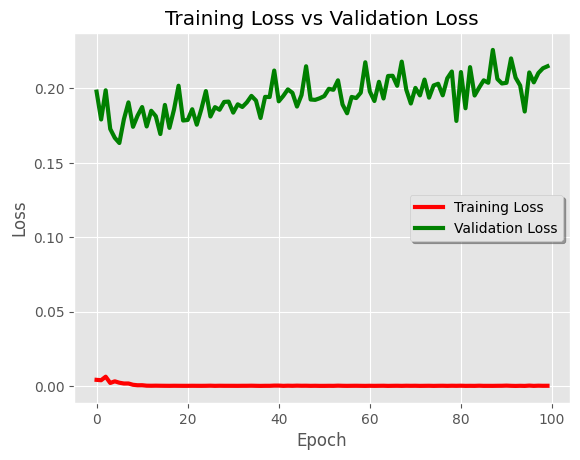

In [132]:
# Training vs Validation Loss Plot
epochs = np.arange(n_epochs)  

plt.style.use('ggplot')
plt.plot(epochs, train_loss_list, label = "Training Loss", color = "red", linewidth = '3')
plt.plot(epochs, val_loss_list, label = "Validation Loss", color = "green", linewidth = '3')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss', color = 'black')
plt.legend(shadow = True, labelcolor = 'black')
plt.savefig('Images/train_vs_val_loss_plot.png')

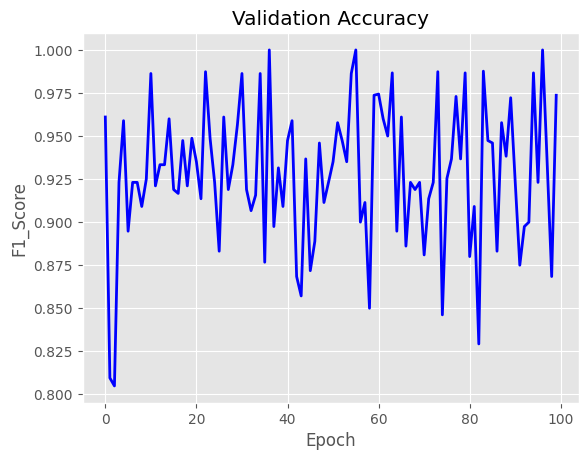

In [133]:
# Validation Accuracy Plot
plt.plot(epochs, f1_score_list, color = 'blue', linewidth = '2')
plt.xlabel('Epoch')
plt.ylabel('F1_Score')
plt.title('Validation Accuracy', color = 'black')
plt.savefig('Images/f1_accuracy_plot.png')

In [134]:
# Save and Load the Model
saved_model = LSTM(EMBEDDING_DIM, 
                   HIDDEN_DIM, 
                   OUTPUT_DIM, 
                   NUM_LAYERS, 
                   BIDIRECTION, 
                   DROPOUT).to(device)

saved_model.load_state_dict(torch.load(PATH))
saved_model.eval()

LSTM(
  (embedding): Embedding(2196013, 300)
  (lstm): LSTM(300, 20, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=40, out_features=27, bias=True)
)

In [135]:
def predict(loader, 
            model):
    predictions = []
    for x, lengths in tqdm(loader):
        with torch.no_grad():
            y_pred = saved_model.forward(x, lengths)
            
            max_len = x.shape[1]

            y_pred = y_pred.view(-1, y_pred.shape[-1])

            max_preds = y_pred.argmax(dim = 1, keepdim = True) # Get the index of the max probability
            predictions_iob = convert_idx_to_tags(slice_list((squeezed_list(max_preds)), max_len), False)
            predictions.append(predictions_iob)
    
    return predictions

        
predictions = predict(test_loader, saved_model)
predictions = np.array(predictions)
predictions = predictions.squeeze().tolist()

100%|███████████████████████████████████████| 981/981 [00:00<00:00, 2088.20it/s]
/var/folders/hk/l7897jp170bb9tbb20n80tz00000gn/T/ipykernel_95115/2706907146.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  predictions = np.array(predictions)


In [144]:
# Creating Dictionary
list_of_dict = []
for i in range(len(predictions)):
    temp_dict = {}
    temp_dict["ID"] = i
    temp_dict["IOB Slot tags"] = ' '.join(predictions[i])
    list_of_dict.append(temp_dict)

# Converting Dictionary to CSV and compress it for submission to CodaLab
tags_df = pd.DataFrame.from_dict(list_of_dict)
tags_df.to_csv('submission.csv.zip', compression = 'zip', index = False)
print(tags_df)

      ID                                      IOB Slot tags
0      0                                        O O B_movie
1      1                          O O O O O B_movie I_movie
2      2                        O O O O O O B_movie I_movie
3      3                                      O O O B_movie
4      4                                      O O O B_movie
..   ...                                                ...
976  976        O O B_movie I_movie I_movie I_movie I_movie
977  977                                  O O I_movie O O O
978  978                O O O O O O B_producer I_producer O
979  979  O O B_director I_director O O O O O B_language...
980  980                   O O B_director O O O O B_country

[981 rows x 2 columns]
